## Convocatoria 1 - Proyecto 1

In [1]:
# Imports
import cv2
import matplotlib.pyplot as plt
import numpy as np

from scipy.ndimage import binary_fill_holes
from scipy.spatial import ConvexHull
from scipy.spatial.distance import pdist

from skimage import io
from skimage.measure import label, regionprops
from skimage.morphology import remove_small_objects

#### 0) Cargar una de las imágenes histológicas

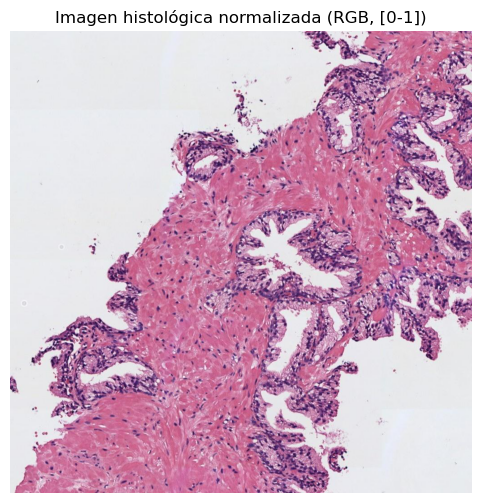

In [2]:
# Utilizar la librería skimage.io para leer la imagen 'histo_x.jpg' en formato RGB.
# Normalizar la imagen para que los píxeles se encuentren en el rango [0, 1]
# Visualizar la imagen

# Leer la imagen histológica 'histo_1.jpg' en formato RGB
rgb_img = io.imread('histo_1.jpg')  # skimage.io carga directamente en RGB

# Convertir los valores de píxeles a tipo float32 y normalizarlos al rango [0, 1]
rgb_img = rgb_img.astype('float32') / 255.0

# Visualizar la imagen normalizada
plt.figure(figsize=(6, 6))
plt.imshow(rgb_img)
plt.title("Imagen histológica normalizada (RGB, [0-1])")
plt.axis('off')
plt.show()

#### 1) Realizar una transformación de color para convertir la imagen al espacio de color CMYK

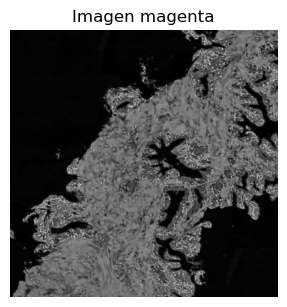

In [3]:
# Extraer la componente magenta de la imagen (que corresponde a la región tisular)
# Visualizar la imagen del canal magenta

# Calcular componente K
K = 1 - np.max(rgb_img, axis=2)

# Evitar divisiones por cero
denominator = 1 - K
denominator[denominator == 0] = 1

# Calcular canales C, M, Y
C = (1 - rgb_img[:, :, 0] - K) / denominator
M = (1 - rgb_img[:, :, 1] - K) / denominator
Y = (1 - rgb_img[:, :, 2] - K) / denominator

# Reemplazar posibles NaNs por 0
C = np.nan_to_num(C)
M = np.nan_to_num(M)
Y = np.nan_to_num(Y)
K = np.nan_to_num(K)

# Escalar a [0, 255] y convertir a uint8 para visualización
C = (C * 255).astype('uint8')
M = (M * 255).astype('uint8')
Y = (Y * 255).astype('uint8')
K = (K * 255).astype('uint8')
CMYK = cv2.merge((C, M, Y, K))

# Visualizar imagen canal Magenta
plt.figure(figsize=(6, 6))
plt.subplot(2, 2, 2)
plt.imshow(M, cmap='gray')
plt.title('Imagen magenta')
plt.axis('off')
plt.tight_layout()
plt.show()

#### 2) Umbralizar la imagen para separar los píxeles del fondo de la región tisular

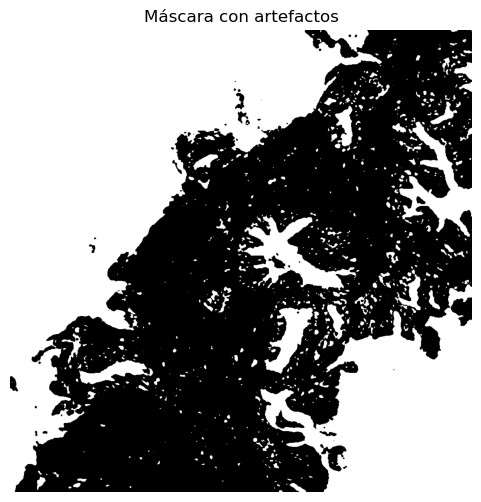

In [4]:
# Aplicar un filtro gaussiano de tamaño 5x5 y después utilizar el método de Otsu de manera que
# los píxeles correspondientes al lumen y al background de la imagen sean 1s y el resto de los píxeles tengan un valor de 0.
# Nota: Recordar que el método de Otsu requiere como input una imagen en el rango [0-255] en formato "uint8".
# Visualizar la máscara resultante

# Aplicar suavizado Gaussiano 5×5
blurred = cv2.GaussianBlur(CMYK, (5, 5), 0)

# Convertir a escala de grises (para usar con Otsu)
gray = cv2.cvtColor(blurred, cv2.COLOR_BGR2GRAY)

# Aplicar umbral de Otsu, salida binaria con valores 0 y 1
_, gauss_mask = cv2.threshold(gray, 0, 1, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Invertir la máscara: fondo a 0, lúmenes a 1
gauss_mask = 1 - gauss_mask

# Visualizar la máscara
plt.figure(figsize=(6, 6))
plt.imshow(gauss_mask, cmap='gray')
plt.title("Máscara con artefactos")
plt.axis("off")
plt.show()

#### 3) Limpiar la imagen eliminando los artefactos de lumen (objetos blancos pequeños que no son lúmenes)

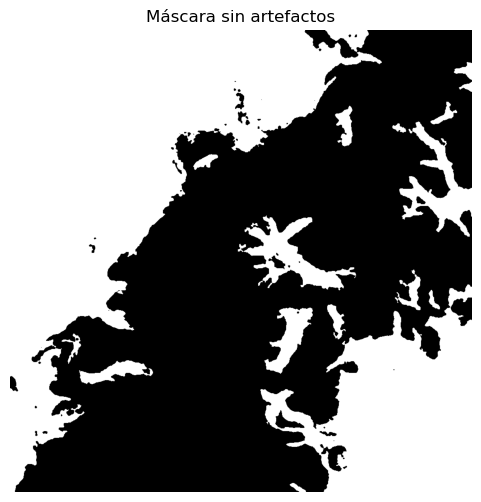

In [5]:
# Utilizar la librería skimage.morphology.remove_small_objects para eliminar aquellos objetos cuya área sea menor a 300 píxeles
# Más información en https://scikit-image.org/docs/dev/api/skimage.morphology.html#skimage.morphology.remove_small_objects
# Visualizaer la máscara resultante

# Convertir la máscara Otsu a booleano para aplicar remove_small_objects
gauss_bool = gauss_mask.astype(bool)

# Eliminar objetos pequeños con área < 300 px (con conectividad 2)
gauss_cleaned_bool = remove_small_objects(gauss_bool, min_size=300, connectivity=2)

# Convertir el resultado a imagen binaria uint8 (valores 0 y 1)
gauss_cleaned = gauss_cleaned_bool.astype(np.uint8)

# Visualizar la máscara limpia
plt.figure(figsize=(6, 6))
plt.imshow(gauss_cleaned, cmap='gray')
plt.title('Máscara sin artefactos')
plt.axis('off')
plt.show()

#### 4) Rellenar con 0s el fondo de la imagen para quedarnos únicamente con los lúmenes

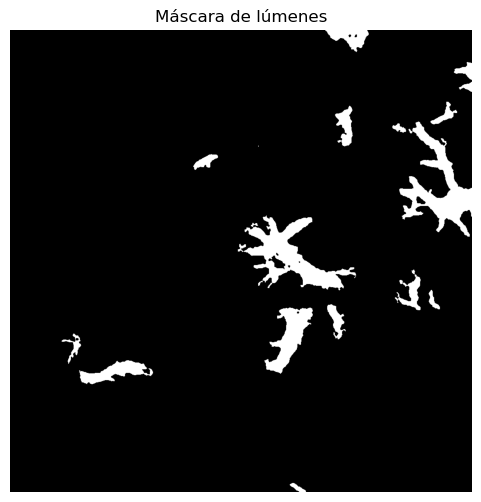

In [6]:
# Aplicar el algoritmo de expansión a partir de semillas (region growing) de manera que únicamente los lúmenes sean blancos
# y el resto de la imagen negra. Pista: utilizar dos semillas. Nota: Se pueden fijar las semillas de manera manual, pero
# se valorará positivamente a aquell@s que desarrollen una función para encontrarlas automáticamente.
# Visualizar la máscara resultante. 

just_lumens = gauss_cleaned.copy()

# Dimensiones de la imagen
h, w = just_lumens.shape

# imagen negra auxiliar para floodFill
ref = np.zeros((h + 2, w + 2), np.uint8)

# Buscar semillas:
seeds = []

vertices = [(0, 0), (0, w-1), (h-1, 0), (h-1, w-1)]
for y, x in vertices:
    if just_lumens[y, x] == 1:
        seeds.append((x, y))  # OpenCV usa (x, y)

if len(seeds) < 4:
    coords = np.argwhere(just_lumens == 1)
    for y, x in coords:
        if (x, y) not in seeds:
            seeds.append((x, y))
        if len(seeds) >= 4:
            break

# Aplicar floodFill desde cada semilla para eliminar regiones conectadas al fondo
for seed in seeds:
    cv2.floodFill(just_lumens, ref, seed, 0)

# Visualizar la máscara
plt.figure(figsize=(6, 6))
plt.imshow(just_lumens, cmap='gray')
plt.title("Máscara de lúmenes")
plt.axis('off')
plt.show()

#### 5) Rellenar los objetos de los lúmenes

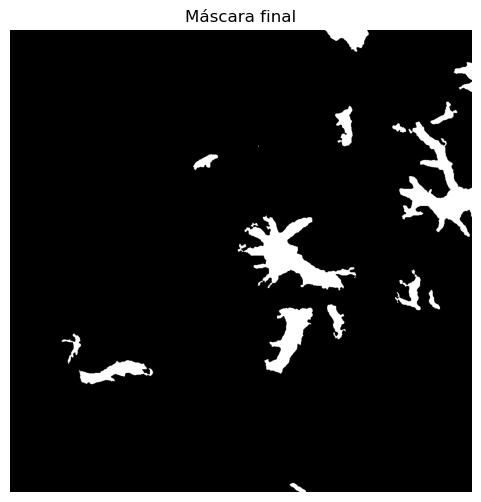

In [7]:
# Rellenar los lúmenes con la función binary_fill_holes de la librería scipy.ndimage.morphology
# Visualizar la máscara resultante

# Aplicar relleno de agujeros internos a la imagen binaria just_lumens
# Convertimos a booleano para aplicar la operación correctamente
filled_lumens = binary_fill_holes(just_lumens > 0)

# Visualizar la máscara
plt.figure(figsize=(6, 6))
plt.imshow(filled_lumens, cmap='gray')
plt.title('Máscara final')
plt.axis('off')
plt.show()

#### 6) Detectar y dibujar los contornos de los lúmenes sobre la imagen original

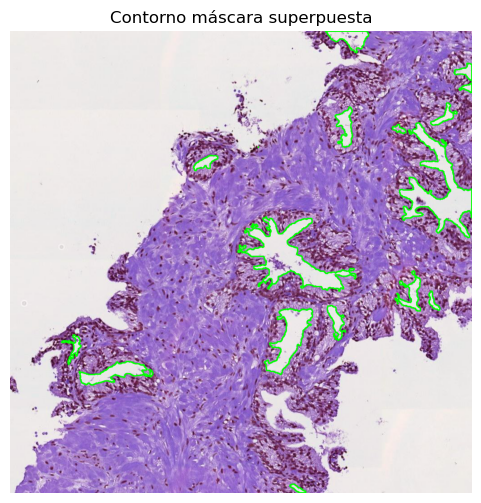

In [8]:
# Dibujar los contornos de los lúmenes en color verde sobre la imagen original RGB. Nota: Utilizar los flags necesarios
# para que los contornos en verde sean perfectamente visibles. 
# Visualizar la imagen superpuesta

# Detectar contornos en la máscara de lúmenes rellenados
contours, _ = cv2.findContours(filled_lumens.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Crear una copia de la imagen original en formato uint8
img_rgb = (rgb_img * 255).astype(np.uint8) if rgb_img.max() <= 1.0 else rgb_img.copy()

# Dibujar los contornos en verde (BGR: (0,255,0)) sobre la imagen original
img_contours = img_rgb.copy()
cv2.drawContours(img_contours, contours, -1, (0, 255, 0), thickness=2)

# Visualizar el resultado
plt.figure(figsize=(6, 6))
plt.imshow(cv2.cvtColor(img_contours, cv2.COLOR_BGR2RGB))
plt.title('Contorno máscara superpuesta')
plt.axis('off')
plt.show()

#### 7) Identificar y cropear el lumen más grande

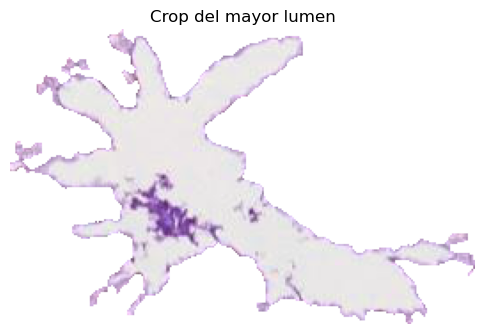

In [9]:
# Determinar cuál es el lumen de mayor área y hacer un crop del mismo sobre la imagen original RGB.
# Visualizar el lumen cropeado.

# Encontrar el contorno de mayor área (lumen más grande)
largest_contour = max(contours, key=cv2.contourArea)

# Obtener bounding box del lumen más grande
x, y, w, h = cv2.boundingRect(largest_contour)

# Recortar el lumen desde la imagen original
cropped_lumen = img_rgb[y:y+h, x:x+w]  # img_rgb es la original en uint8 formato BGR

# Crear una máscara vacía del tamaño del crop
mask_crop = np.zeros((h, w), dtype=np.uint8)

# Dibujar el lumen más grande dentro de la máscara (ajustado al crop)
cv2.drawContours(mask_crop, [largest_contour - [x, y]], -1, 1, thickness=-1)

# Crear una imagen blanca del mismo tamaño que el crop
crop_white_bg = np.ones_like(cropped_lumen) * 255

# Copiar los valores del lumen sobre el fondo blanco usando la máscara
for c in range(3):  # Para cada canal (B, G, R)
    crop_white_bg[:, :, c] = np.where(mask_crop == 1, cropped_lumen[:, :, c], 255)

# Visualizar el lumen aislado sobre fondo blanco
plt.figure(figsize=(6, 6))
plt.imshow(cv2.cvtColor(crop_white_bg, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Crop del mayor lumen')
plt.show()

#### 8) Extraer 13 características geométricas que permitan caracterizar el lumen recortado 

In [10]:
# Calcular las siguientes características del crop del lumen de mayor área, redondeando su valor hasta el cuarto decimal.
# 1) Área
# 2) Área de la bounding box
# 3) Área convexa
# 4) Exentricidad
# 5) Diámetro equivalente
# 6) Extensión
# 7) Diámetro Feret
# 8) Longitud del eje mayor
# 9) Longitud del eje menor
# 10) Orientación
# 11) Perímetro
# 12) Solidez
# 13) Compacidad

# Crear una máscara
mask_crop = np.zeros((h, w), dtype=np.uint8)
cv2.drawContours(mask_crop, [largest_contour - [x, y]], -1, 1, thickness=-1)

# Calcular propiedades con regionprops
props = regionprops(label(mask_crop))[0]

# Ajustar puntos del contorno al sistema de coordenadas del crop
contour_points = largest_contour - [x, y]

# 1) Área
area = np.round(props.area, 4)

# 2) Área de la bounding box
bbox_area = np.round(props.bbox_area, 4)

# 3) Área convexa
hull = ConvexHull(contour_points.squeeze())
convex_area = np.round(hull.volume, 4)  # .volume = área 2D para convex hull

# 4) Excentricidad
eccentricity = np.round(props.eccentricity, 4)

# 5) Diámetro equivalente
equiv_diameter = np.round(props.equivalent_diameter, 4)

# 6) Extensión
extent = np.round(props.extent, 4)

# 7) Diámetro Feret:
feret_diameter = np.round(np.max(pdist(contour_points.squeeze())), 4)

# 8) Longitud del eje mayor
major_axis_length = np.round(props.major_axis_length, 4)

# 9) Longitud del eje menor
minor_axis_length = np.round(props.minor_axis_length, 4)

# 10) Orientación
orientation = np.round(props.orientation, 4)

# 11) Perímetro
perimeter = np.round(props.perimeter, 4)

# 12) Solidez
solidity = np.round(props.solidity, 4)

# 13) Compacidad:
compacity = np.round((perimeter**2) / (4 * np.pi * area), 4)

features = {
    "Área": area,
    "Área bounding box": bbox_area,
    "Área convexa": convex_area,
    "Excentricidad": eccentricity,
    "Diámetro equivalente": equiv_diameter,
    "Extensión": extent,
    "Diámetro Feret": feret_diameter,
    "Longitud eje mayor": major_axis_length,
    "Longitud eje menor": minor_axis_length,
    "Orientación": orientation,
    "Perímetro": perimeter,
    "Solidez": solidity,
    "Compacidad": compacity
}

# Mostrar resultados
print("\nCaracterísticas geométricas del lumen más grande:\n")
for k, v in features.items():
    print(f"{k}: {v}")


Características geométricas del lumen más grande:

Área: 14676.0
Área bounding box: 43492.0
Área convexa: 32107.5
Excentricidad: 0.8486
Diámetro equivalente: 136.697
Extensión: 0.3374
Diámetro Feret: 267.5855
Longitud eje mayor: 244.9458
Longitud eje menor: 129.5711
Orientación: 1.0246
Perímetro: 1480.0063
Solidez: 0.4527
Compacidad: 11.8771
